In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


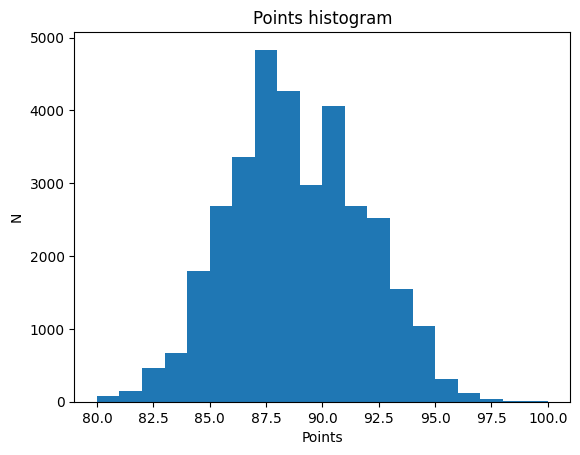

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.17168206, -0.03912265, -0.19116372, ...,  0.00403659,
        -0.10422879,  0.09513361],
       [ 0.16077818, -0.08582296, -0.00711173, ..., -0.03118337,
        -0.24915083,  0.12139153],
       [ 0.2803441 ,  0.01169281, -0.09186534, ...,  0.01064287,
        -0.02108565, -0.03438236],
       ...,
       [ 0.51646465, -0.10095321, -0.0379984 , ...,  0.12300111,
        -0.2052176 ,  0.13895024],
       [ 0.5883683 , -0.07911789,  0.2125521 , ..., -0.16954349,
        -0.10716922,  0.17429774],
       [ 0.33363354,  0.01889583, -0.12045833, ..., -0.12851454,
        -0.11018372, -0.11380527]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

27/27 [==============================] - 2s 9ms/step - loss: 0.7094 - accuracy: 0.3681


[0.7094017863273621, 0.368109792470932]

In [ ]:
model.evaluate(valid_data)

4/4 [==============================] - 0s 10ms/step - loss: 0.7094 - accuracy: 0.3728


[0.7093724608421326, 0.37280571460723877]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
27/27 [==============================] - 9s 223ms/step - loss: 0.6910 - accuracy: 0.5570 - val_loss: 0.6769 - val_accuracy: 0.6278
Epoch 2/5
27/27 [==============================] - 5s 173ms/step - loss: 0.6636 - accuracy: 0.6351 - val_loss: 0.6493 - val_accuracy: 0.6275
Epoch 3/5
27/27 [==============================] - 4s 138ms/step - loss: 0.6295 - accuracy: 0.6462 - val_loss: 0.5978 - val_accuracy: 0.6302
Epoch 4/5
27/27 [==============================] - 5s 200ms/step - loss: 0.5760 - accuracy: 0.6803 - val_loss: 0.5308 - val_accuracy: 0.7269
Epoch 5/5
27/27 [==============================] - 5s 187ms/step - loss: 0.5129 - accuracy: 0.7200 - val_loss: 0.4712 - val_accuracy: 0.7962


In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 0s 13ms/step - loss: 0.4662 - accuracy: 0.7953


[0.4662367105484009, 0.7952989935874939]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

4/4 [==============================] - 0s 17ms/step - loss: 0.6929 - accuracy: 0.5278


[0.6929319500923157, 0.5278190970420837]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
27/27 [==============================] - 9s 150ms/step - loss: 0.6665 - accuracy: 0.6278 - val_loss: 0.6400 - val_accuracy: 0.6275
Epoch 2/5
27/27 [==============================] - 3s 97ms/step - loss: 0.5914 - accuracy: 0.6666 - val_loss: 0.5139 - val_accuracy: 0.7676
Epoch 3/5
27/27 [==============================] - 2s 63ms/step - loss: 0.4544 - accuracy: 0.7975 - val_loss: 0.4146 - val_accuracy: 0.8054
Epoch 4/5
27/27 [==============================] - 2s 75ms/step - loss: 0.3770 - accuracy: 0.8331 - val_loss: 0.3846 - val_accuracy: 0.8259
Epoch 5/5
27/27 [==============================] - 1s 54ms/step - loss: 0.3479 - accuracy: 0.8493 - val_loss: 0.3781 - val_accuracy: 0.8301


In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 0s 15ms/step - loss: 0.3698 - accuracy: 0.8283


[0.3698042631149292, 0.8283249139785767]